In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image, ImageFilter
import os
import time
import json
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import sagemaker
import mxnet as mx
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet

In [3]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

# Unzip and upload the data

In [5]:
!mkdir ../dataset

### Load archives from s3

In [6]:
!aws s3 cp --recursive s3://ml-for-seismic-data-interpretation/dataset/ ../dataset/

download: s3://ml-for-seismic-data-interpretation/dataset/test.zip to ../dataset/test.zip
download: s3://ml-for-seismic-data-interpretation/dataset/train-val.zip to ../dataset/train-val.zip


In [7]:
!unzip -q ../dataset/train-val.zip -d ../dataset

In [8]:
!unzip -q ../dataset/test.zip -d ../dataset

### Upload folders to s3 bucket

In [11]:
!aws s3 cp --quiet --recursive ../dataset/train s3://ml-for-seismic-data-interpretation/dataset_unzip/train
!aws s3 cp --quiet --recursive ../dataset/validation s3://ml-for-seismic-data-interpretation/dataset_unzip/validation
!aws s3 cp --quiet --recursive ../dataset/train_annotation s3://ml-for-seismic-data-interpretation/dataset_unzip/train_annotation
!aws s3 cp --quiet --recursive ../dataset/validation_annotation s3://ml-for-seismic-data-interpretation/dataset_unzip/validation_annotation

## Dataset Structure


    |- train
                 |
                 | - 1000.jpg
                 | - 1001.jpg
    |- validation
                 |
                 | - 1010.jpg
                 | - 1073.jpg              
    |- train_annotation
                 |
                 | - 1000.png
                 | - 1001.png
    |- validation_annotation
                 |
                 | - 1010.png   
                 | - 1073.png

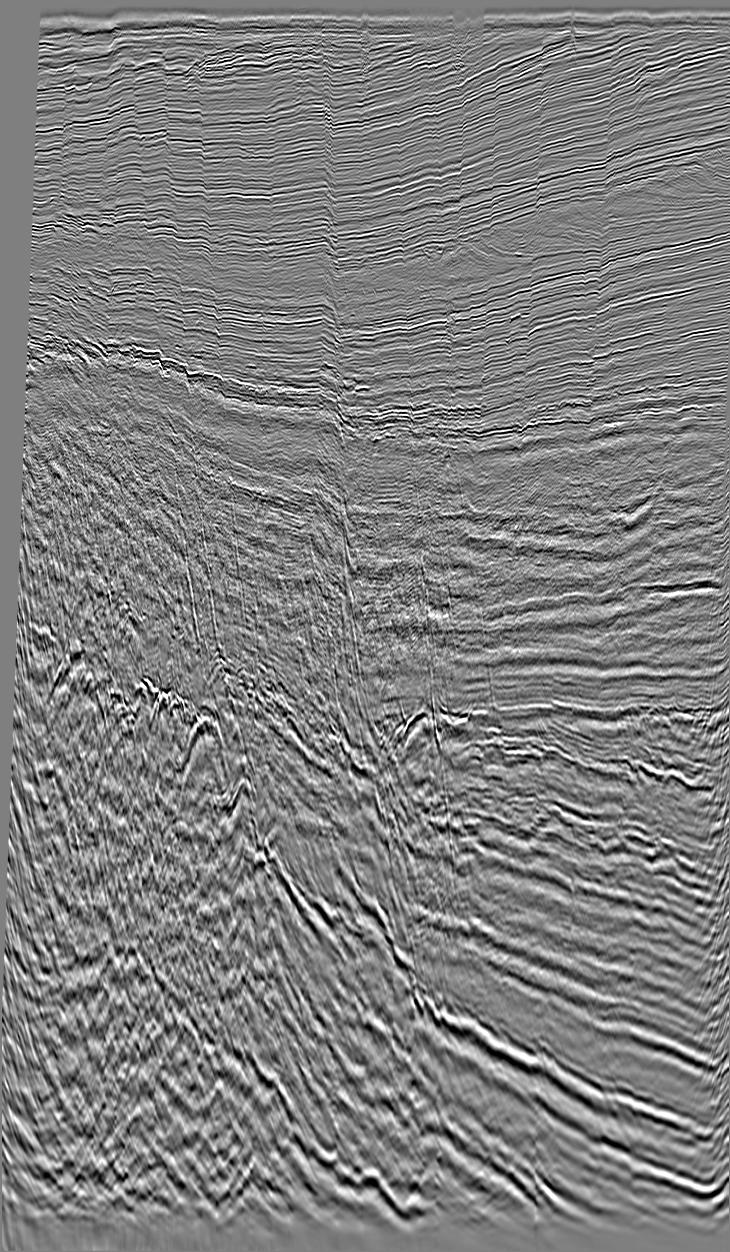

In [12]:
Image.open('../dataset/train/kerry_526.jpg')

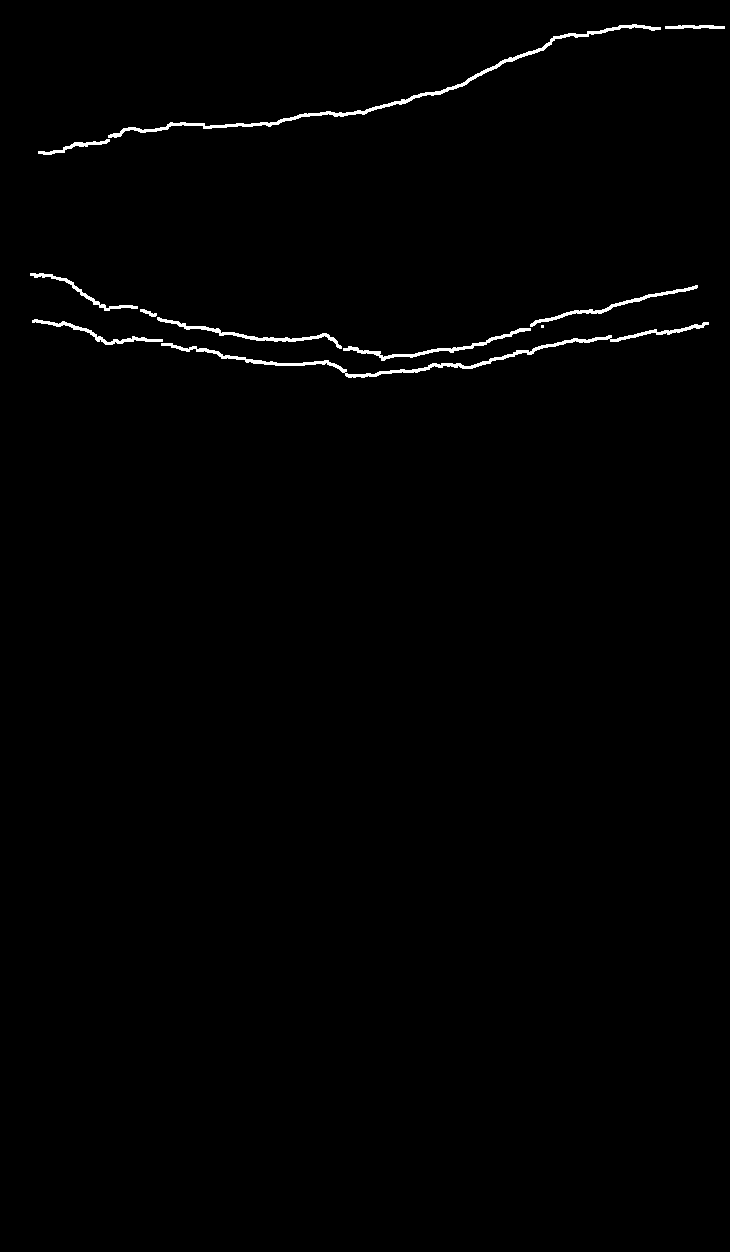

In [13]:
Image.open('../dataset/train_annotation/kerry_526.png')

# Train and deploy network

### Create dataset

In [14]:
train_s3 = sagemaker.s3_input(s3_data='s3://ml-for-seismic-data-interpretation/dataset_unzip', distribution='FullyReplicated')

### Define the estimator

In [15]:
seismic_unet_job = 'Seismic-unet-job-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

seismic_estimator = MXNet(entry_point='seismic.py',
                          base_job_name=seismic_unet_job,
                          role=role,
                          py_version="py3",
                          framework_version="1.6.0",
                          train_instance_count=1,
                          train_instance_type='ml.p3.2xlarge',
                          hyperparameters={
                            'learning_rate': 0.003,
                            'batch_size': 2,
                            'epochs': 5
                          })

### Train the model

In [ ]:
seismic_estimator.fit({'train': train_s3})

2020-07-14 21:41:14 Starting - Starting the training job.

### Create the endpoint and deploy the model there

In [ ]:
seismic_endpoint = 'Seismic-endpoint-webinar'

seismic_predictor = seismic_estimator.deploy(instance_type='ml.c5.xlarge', 
                                            initial_instance_count=1,
                                            endpoint_name=seismic_endpoint)

# Visualize predictions

In [ ]:
from seismic import IM_SIZE

In [ ]:
base_dir = '../dataset/validation'

In [ ]:
base_dir = '../dataset/test'

In [ ]:
files = os.listdir(base_dir)
i = np.random.randint(len(files))
im_path = os.path.join(base_dir, files[i])
an_path = base_dir + '_annotation/'+ files[i][:-3] + 'png'

input_img = Image.open(im_path)
an_img = Image.open(an_path)
im_w, im_h = input_img.size

image = mx.image.imread(im_path, 0)
image = mx.image.imresize(image, IM_SIZE,IM_SIZE)
image = image.astype(np.float32)
image *= 1.0/image.max()
image =  mx.nd.transpose(image, (2, 0, 1))
image = mx.nd.expand_dims(image, axis=0)
image = image.asnumpy() 
image = np.array(image*255).astype(np.uint8)
response = seismic_predictor.predict(image)
img_out = np.array(response)
output =np.array(Image.fromarray(img_out.astype('uint8'), mode='P').resize(( im_w, im_h) ))

plt.figure(figsize=(14, 14))
plt.title('Image')
plt.imshow(input_img, cmap=plt.cm.gray)
plt.figure(figsize=(14, 14))
plt.title('Ground Truth')
plt.imshow(an_img, cmap=plt.cm.gray)
plt.figure(figsize=(14, 14))
plt.title('Prediction')
plt.imshow(output, cmap=plt.cm.gray)

In [111]:
seismic_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: Seismic-endpoint-webinar
INFO:sagemaker:Deleting endpoint with name: Seismic-endpoint-webinar


In [ ]:
!rm -r ../dataset